# Part 3 - Using x-vectors as embeddings for classification tasks

In this section, you will learn how to use speech embedding models to perform speech classification tasks.

You will be working in a Google Colab environment.

A few important notes:

* Make sure to copy this notebook to your own drive so your progress is saved.
* Change the runtime type to GPU to achieve faster inference with our embedding model. (To do this, click on 'Runtime' → 'Change runtime type' in the toolbar.)
* You can add any necessary imports (e.g., when selecting classifiers) across different code cells.

## Imports

In [15]:
!pip install speechbrain

In [16]:
import os
import torch
import random
import librosa
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from speechbrain.inference.classifiers import EncoderClassifier


device = "cuda" if torch.cuda.is_available() else "cpu"

## 3.1 - SPEECHCOMMANDS Dataset

The SPEECHCOMMANDS dataset consists of approximately 2,000 speakers and around 100,000 utterances.

The code below downloads both the training and validation splits.

In [17]:
# DS loading - takes aprroximately 2-3 mins, be patient.
dataset_train = torchaudio.datasets.SPEECHCOMMANDS(
    root="./",
    download=True,
    subset="training"
)

The code below loads the embedding model to the device, and sets model mode to evaluation.

In [18]:
# Given code
xvector_model = EncoderClassifier.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb", savedir="./")
xvector_model.device = device
xvector_model.to(device)
xvector_model.eval()

/usr/local/lib/python3.11/dist-packages/speechbrain/utils/checkpoints.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=device

EncoderClassifier(
  (mods): ModuleDict(
    (compute_features): Fbank(
      (compute_STFT): STFT()
      (compute_fbanks): Filterbank()
      (compute_deltas): Deltas()
      (context_window): ContextWindow()
    )
    (mean_var_norm): InputNormalization()
    (embedding_model): ECAPA_TDNN(
      (blocks): ModuleList(
        (0): TDNNBlock(
          (conv): Conv1d(
            (conv): Conv1d(80, 1024, kernel_size=(5,), stride=(1,))
          )
          (activation): ReLU()
          (norm): BatchNorm1d(
            (norm): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (1): SERes2NetBlock(
          (tdnn1): TDNNBlock(
            (conv): Conv1d(
              (conv): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,))
            )
            (activation): ReLU()
            (norm): BatchNorm1d(
              (norm): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
     

## 3.2 - Speaker Classification

Each sample on the file tree of SPEECHCOMMANDS includes a unique speaker id.

The below code extracts all the speaker ids in the dataset to `spkr_ids` list.

In [19]:
# Given code
wav_paths = [os.path.join(root, file) for root, dirs, files in os.walk('./SpeechCommands/speech_commands_v0.02') for file in files if file.endswith('.wav')]
spkr_ids = list({os.path.basename(wav_path).split('_')[0] for wav_path in wav_paths})

### 3.2.1 - t-SNE Projection

t-SNE projection is similar to PCA. We will use it to visualize how our embedding model maps the speech files onto a space relevant to our task.

You can read more about t-SNE here:
https://scikit-learn.org/stable/modules/manifold.html#t-distributed-stochastic-neighbor-embedding-t-sne

And about sklearn's TSNE implementation here:
https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

There is no need to dive deeply into the implementation or technical details of t-SNE, but feel free to explore further and broaden your horizons. :)

In this section, you will gain an understanding of how x-vector embeddings map speech data onto another latent space.

Follow these instructions:

1. Select 10 speakers from the spkr_ids list. Choose speakers with more than 100 utterances, and ensure all selected speakers have a similar number of samples.
1. For the chosen speakers, create a list of all wav files associated with them (across all different classes).
1. Ensure your list contains at least 1,000 wav files, with an even distribution of samples across speakers.
1. For each wav file in the list, extract its embedding and the corresponding spkr_id label.
1. Generate a scatter plot showing the t-SNE projection of the extracted embeddings. Assign a unique color to each speaker's data points on the scatter plot.

**Hint**: Use two lists while generating the embeddings—one for the embeddings and another for the speaker IDs.

**Notes**:
* Use a 2-dimensional t-SNE projection.
* Include an appropriate title and labels for the axes in the plot.

Chosen speakers: ['54aecbd5', '679463fc', '24a3e589', '54ad8f22', '9a76f8c3', 'ed032775', '5f9cd2eb', 'a045368c', 'b83c1acf', '2e75d37a']


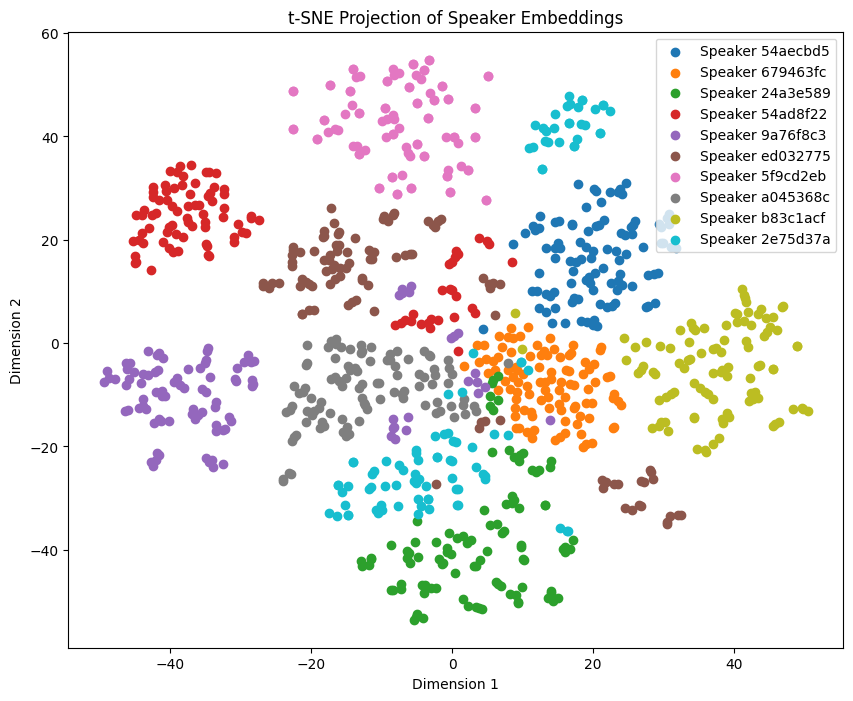

In [20]:
chosen_spkrs = []
for spkr_id in spkr_ids:
  cnt = 0
  for wav_path in wav_paths:
    if spkr_id in wav_path:
      cnt += 1
    if cnt > 100:
      chosen_spkrs.append(spkr_id)
      break
  if len(chosen_spkrs) >= 10:
    break

# print(f"Chosen speakers: {chosen_spkrs}")
# Create a list of wav files and their corresponding speaker labels
wav_files = []
labels = []
samples_per_speaker = 100
for spkr_id in chosen_spkrs:
    # Filter WAV paths for the current speaker and exclude background noise
    speaker_wavs = [
        wav_path for wav_path in wav_paths
        if spkr_id in wav_path and "_background_noise_" not in wav_path
    ]

    # Limit the number of WAV files per speaker to `samples_per_speaker`
    selected_wavs = speaker_wavs[:samples_per_speaker]
    wav_files.extend(selected_wavs)

    # Add the corresponding labels for the selected WAV files
    num_samples = min(samples_per_speaker, len(speaker_wavs))
    labels.extend([spkr_id] * num_samples)

# Check if we have at least 1,000 samples
if len(wav_files) < 1000:
    raise ValueError("Not enough WAV files. Adjust the criteria or add more speakers.")

embeddings = []
for wav_file in wav_files:
    signal, sr = torchaudio.load(wav_file)
    signal = signal.to(device)  # Move to GPU if available
    embedding = xvector_model.encode_batch(signal)  # Extract embedding
    embeddings.append(embedding.squeeze().cpu().numpy())
embeddings_np = np.array(embeddings)
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings_np)

# print(f"Collected {len(embeddings)} embeddings for the chosen speakers.:{embeddings}")
plt.figure(figsize=(10, 8))
for spkr_id in chosen_spkrs:
    spkr_indices = [i for i, label in enumerate(labels) if label == spkr_id]
    plt.scatter(
        reduced_embeddings[spkr_indices, 0],
        reduced_embeddings[spkr_indices, 1],
        label=f"Speaker {spkr_id}",
    )

plt.title("t-SNE Projection of Speaker Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.show()



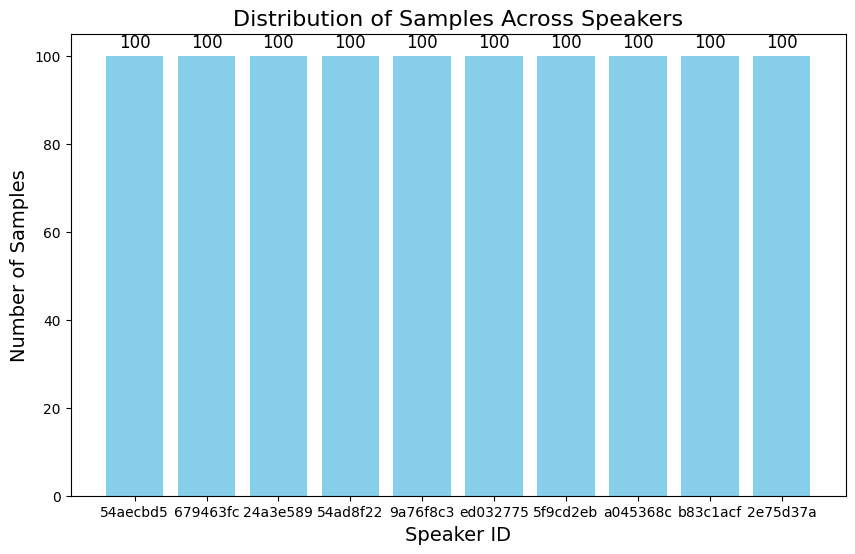

In [21]:
# Count the number of samples for each speaker
speaker_sample_counts = {spkr_id: labels.count(spkr_id) for spkr_id in chosen_spkrs}

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(speaker_sample_counts.keys(), speaker_sample_counts.values(), color='skyblue')

# Add labels and title
plt.title("Distribution of Samples Across Speakers", fontsize=16)
plt.xlabel("Speaker ID", fontsize=14)
plt.ylabel("Number of Samples", fontsize=14)

# Add value labels above the bars
for spkr_id, count in speaker_sample_counts.items():
    plt.text(spkr_id, count + 2, str(count), ha='center', fontsize=12)

# Show the plot
plt.show()


### 3.2.2 - Classify Speakers

On this section, you will classify different speakers using embeddings from our embedding model.

1. Collect wav files of **20** different speakers. (Follow the same guidelines from 3.2.1.1).
1. Choose three different classifiers from `sklearn` library (e.g., SVM, Decision Tree, Random Forest, LDA, etc.)
1. Add a table of the results, using 5-Fold Crossv-Validation (CV) as specified in the exercise PDF. Discuss the results.

**Note**: Present mean and standard-deviation of classification results per each classifier.


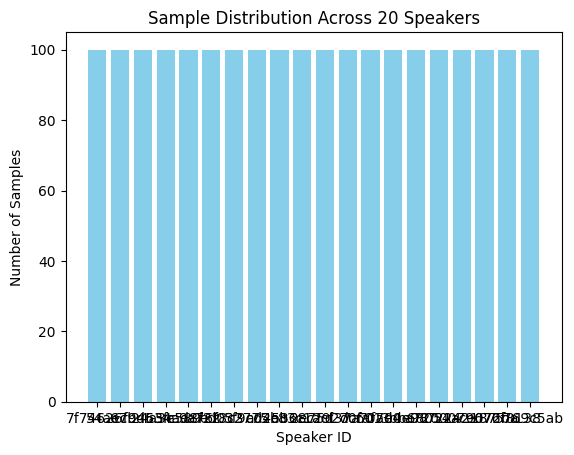

In [22]:
# Select 20 speakers with more than 100 utterances
chosen_spkrs = []
samples_per_speaker = 100
for spkr_id in spkr_ids:
    cnt = 0
    for wav_path in wav_paths:
        if "_background_noise_" in wav_path.split('/'):
            continue
        if spkr_id in wav_path:
            cnt += 1
        if cnt >= samples_per_speaker:
            chosen_spkrs.append(spkr_id)
            break
    if len(chosen_spkrs) >= 20:
        break

# Ensure even distribution of samples
wav_files = []
labels = []

for spkr_id in chosen_spkrs:
    speaker_wavs = [
        wav_path for wav_path in wav_paths
        if spkr_id in wav_path and "_background_noise_" not in wav_path
    ]
    selected_wavs = speaker_wavs[:samples_per_speaker]
    wav_files.extend(selected_wavs)
    labels.extend([spkr_id] * min(samples_per_speaker, len(speaker_wavs)))

# Verify that the collected data is evenly distributed

speaker_sample_counts = {spkr_id: labels.count(spkr_id) for spkr_id in chosen_spkrs}
plt.bar(speaker_sample_counts.keys(), speaker_sample_counts.values(), color='skyblue')
plt.title("Sample Distribution Across 20 Speakers")
plt.xlabel("Speaker ID")
plt.ylabel("Number of Samples")
plt.show()


In [23]:
embeddings = []
for wav_file in wav_files:
    signal, sr = torchaudio.load(wav_file)
    signal = signal.to(device)  # Move to GPU if available
    embedding = xvector_model.encode_batch(signal)  # Extract embedding
    embeddings.append(embedding.squeeze().cpu().numpy())
embeddings_np = np.array(embeddings)
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings_np)


In [24]:
# Encode speaker IDs as numerical labels
encoder = LabelEncoder()
numeric_labels = encoder.fit_transform(labels)

# Convert embeddings and labels to numpy arrays
X = np.array(embeddings)  # Assuming embeddings are collected previously
y = np.array(numeric_labels)

# Define classifiers
classifiers = {
    "LDA": LinearDiscriminantAnalysis(),# we added this later because SVM takes a lot of time in the next section
    "SVM": SVC(kernel='linear', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}

# Perform 5-Fold Cross-Validation
results = {}
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

for name, clf in classifiers.items():
    scores = cross_val_score(clf, X, y, cv=skf, scoring='accuracy')
    results[name] = {
        "Mean Accuracy": np.mean(scores),
        "Std Deviation": np.std(scores)
    }

# Print results as a table
print("Classifier Performance:")
results_df = pd.DataFrame(results).T
print(results_df)


                     Mean Accuracy  Std Deviation
LDA                         0.9635       0.009301
SVM                         0.9690       0.009434
Random Forest               0.8775       0.008515
Logistic Regression         0.9655       0.005788


## 3.3 - Command Classification

The SPEECHCOMMANDS dataset was originally created to train speech models for classifying different commands.

In this section, we will evaluate our embedding model on a command classification task.

### 3.3.1 - t-SNE Projection



Repeat the process from Section 3.2.1, but this time use the commands as labels in the t-SNE projection.

1. Select only **three** commands from the following set: {left, happy, marvin, go, zero, right}.
1. Randomly select 1,000 samples for each chosen command.
1. This should result in a dataset of 3,000 samples, divided into three classes (the three commands you chose), with 1,000 samples per command.
1. Generate a scatter plot of the t-SNE projection and discuss the results in your report.

Number of wav files: 3000
Number of labels: 3000


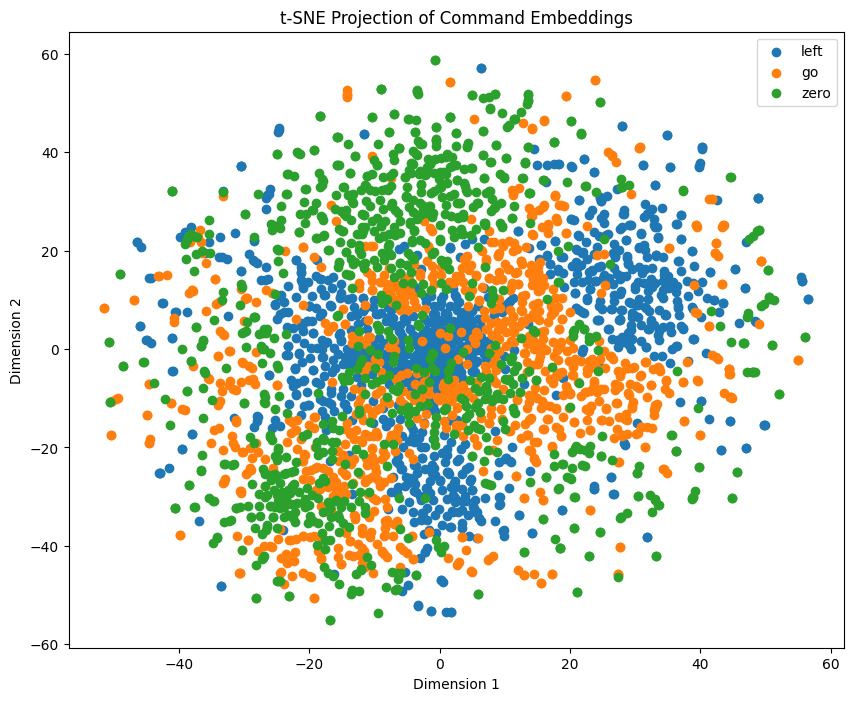

In [25]:
# Select commands
chosen_commands = ["left", "go", "zero"]

# Filter wav paths for the selected commands
command_wav_files = {command: [] for command in chosen_commands}
for wav_path in wav_paths:
    for command in chosen_commands:
        if command in wav_path and "_background_noise_" not in wav_path:
            command_wav_files[command].append(wav_path)

# Randomly select 1,000 samples per command
samples_per_command = 1000
final_wav_files = []
final_labels = []
for command in chosen_commands:
    selected_wavs = random.sample(command_wav_files[command], samples_per_command)
    final_wav_files.extend(selected_wavs)
    final_labels.extend([command] * samples_per_command)

# Extract embeddings
embeddings = []
for wav_file in final_wav_files:
    signal, sr = torchaudio.load(wav_file)
    signal = signal.to(device)  # Move signal to GPU if available
    embedding = xvector_model.encode_batch(signal)  # Extract embedding
    embeddings.append(embedding.squeeze().cpu().detach().numpy())

embeddings_np = np.array(embeddings)
# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings_np)

# Generate scatter plot
plt.figure(figsize=(10, 8))
for command in chosen_commands:
    indices = [i for i, label in enumerate(final_labels) if label == command]
    plt.scatter(
        reduced_embeddings[indices, 0],
        reduced_embeddings[indices, 1],
        label=command,
    )

plt.title("t-SNE Projection of Command Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.show()


### 3.3.2 - Classify Commands

Repeat the process from Section 3.2.2, but this time use commands as labels for classification.

1. Use the embeddings from Section 3.3.1 to classify the different classes.
1. Display a table of the classification results and discuss your findings in the report.


**Note**: Present the classification results using 5-fold cross-validation (CV).

**Note**: Present mean and standard-deviation of classification results per each classifier.

In [26]:
# Load embeddings and labels
X = embeddings_np
label_encoder = LabelEncoder()
y = final_labels
y_encoded = label_encoder.fit_transform(y)


# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(final_labels)

# Define classifiers
classifiers = {
    "LDA": LinearDiscriminantAnalysis(),
    'Logistic Regression': LogisticRegression(max_iter=5000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# Define StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize a dictionary to hold results
results = {}

# Perform 5-fold CV for each classifier
for name, clf in classifiers.items():
    accuracy_scores = []

    # Cross-validation
    for train_index, test_index in kf.split(X, y_encoded):
        clf.fit(X[train_index], y_encoded[train_index])
        y_pred = clf.predict(X[test_index])

        # Collect accuracy for each fold
        accuracy_scores.append(accuracy_score(y_encoded[test_index], y_pred))

    # Calculate mean and standard deviation of accuracy
    results[name] = {
        'Mean Accuracy': np.mean(accuracy_scores),
        'Std Deviation': np.std(accuracy_scores)
    }

# Convert the results dictionary to a DataFrame for easy visualization
results_df = pd.DataFrame(results).T

# Print results in tabular format
print("Classifier Performance:")
print(results_df)


Classifier Performance:
                     Mean Accuracy  Std Deviation
LDA                       0.893667       0.014735
Logistic Regression       0.858333       0.006912
Random Forest             0.823000       0.012311


### Good Luck!